In [1]:
# from jax import config
# config.update("jax_enable_x64", True)

In [1]:
from jax import config
config.update("jax_debug_nans", False)

In [2]:
import os 
from datetime import datetime

import numpy as np
import jax.numpy as jnp
import jax
import optax

import dask

import matplotlib.pyplot as plt

from water_balance_jax import wbm_jax, construct_Kpet_vec
from initial_params import initial_params_main, initial_params_vic, constants
from param_bounds import params_main_lower, params_main_upper, params_vic_lower, params_vic_upper
from read_inputs import read_inputs
from param_names import param_names_main, param_names_vic
from prediction import make_prediction_main, make_prediction_vic
from global_paths import project_data_path

In [3]:
# ############
# ### Dask ###
# ############
# from dask_jobqueue import SLURMCluster

# cluster = SLURMCluster(
#     # account="pches",
#     account="open",
#     cores=1,
#     memory="5GiB",
#     walltime="01:00:00"
# )
# cluster.scale(jobs=30)  # ask for jobs

# from dask.distributed import Client
# client = Client(cluster)
# client

### Preliminaries

In [4]:
def train_and_store(subset_name,
                    obs_name,
                    _error_fn,
                    error_fn_name,
                    initial_theta,
                    params_lower,
                    params_upper,
                    param_names,
                    n_epochs = 30,
                    batch_size = 2**5,
                    opt = 'adam',
                    learning_rate = 1e-3,
                    val_inds = [],
                    reg_const = 0.001):
    #############################################
    # Loss function with correct error metric
    ############################################
    # Prediction loss
    def prediction_loss_vic(theta, constants, x_forcing_nt, x_forcing_nyrs, x_maps, ys):
        prediction = make_prediction_vic(theta, constants, x_forcing_nt, x_forcing_nyrs, x_maps)
        return _error_fn(prediction, ys)
    
    def prediction_loss_main(theta, constants, x_forcing_nt, x_forcing_nyrs, x_maps, ys):
        prediction = make_prediction_main(theta, constants, x_forcing_nt, x_forcing_nyrs, x_maps)
        return _error_fn(prediction, ys)

    if obs_name == "VIC":
        prediction_loss = prediction_loss_vic
        initial_params = initial_params_vic
    else:
        prediction_loss = prediction_loss_main
        initial_params = initial_params_main
    
    # Regularization loss
    def reg_loss(theta, initial_params, params_lower, params_upper):
        return jnp.nansum((theta - initial_params)**2 / ((theta - params_lower) * (params_upper - theta)))
    
    # Total loss
    def loss_fn(theta, reg_const, initial_params, params_lower, params_upper, constants,
                x_forcing_nt, x_forcing_nyrs, x_maps, ys):
        return prediction_loss(theta, constants, x_forcing_nt, x_forcing_nyrs, x_maps, ys) + \
                reg_const * reg_loss(theta, initial_params, params_lower, params_upper)
    
    # jit and vmap it
    pred_loss_value = jax.jit(jax.vmap(prediction_loss, in_axes=(None, None, 0, 0, 0, 0), out_axes=0))
    loss_value_and_grad = jax.jit(jax.vmap(jax.value_and_grad(loss_fn), in_axes=(None, None, None, None, None, None, 0, 0, 0, 0), out_axes=0))

    ###########################
    # Setup
    ###########################
    # Params
    if obs_name == "VIC":
        param_names = param_names_vic
    else:
        param_names = param_names_main
        
    # Read data
    ys, x_forcing_nt, x_forcing_nyrs, x_maps = read_inputs(subset_name, obs_name, True)
    N = ys.shape[0]
    
    # Get train/val split over space
    if len(val_inds) > 0:
        ys_val, x_forcing_nt_val, x_forcing_nyrs_val, x_maps_val = ys[val_inds], x_forcing_nt[val_inds], x_forcing_nyrs[val_inds], x_maps[val_inds]
        train_inds = np.array([n for n in np.arange(N) if n not in val_inds])
        ys_train, x_forcing_nt_train, x_forcing_nyrs_train, x_maps_train = ys[train_inds], x_forcing_nt[train_inds], x_forcing_nyrs[train_inds], x_maps[train_inds]
    else:
        ys_train, x_forcing_nt_train, x_forcing_nyrs_train, x_maps_train = ys, x_forcing_nt, x_forcing_nyrs, x_maps
    
    # Define mini-batch hyper-parameters
    N_train = ys_train.shape[0]
    n_minibatches = int(np.ceil(N_train / batch_size))

    # Initial parameters
    theta = initial_theta

    # Optimizer
    if opt == 'adam':
        adam = optax.adam(learning_rate=learning_rate)
        opt_fn = adam.update
        opt_state = adam.init(theta)
    elif opt == 'sgd':
        learning_rate = 1e-5
        opt_state = None
        def sgd(gradients, state):
            return -learning_rate * gradients, state
        opt_fn = sgd

    # Loss
    train_loss_out = np.empty(n_epochs + 1)
    pred_loss_out = np.empty(n_epochs + 1)
    reg_loss_out = np.empty(n_epochs + 1)
    val_loss_out = np.empty(n_epochs + 1)

    #####################
    # Initial results
    #####################
    
    # Where to store results
    datetime_str = datetime.now().strftime('%Y%m%d-%H%M')
    random_str = str(abs(theta[0])).replace('.','')[:5] # used to discern different starting values
    training_name = f"{error_fn_name}_{str(n_epochs)}epochs_{str(batch_size)}batchsize_{str(reg_const)}reg_{random_str}r"
    if len(val_inds) > 0:
        training_name += f"_{str(val_inds[0])}val"

    out_file_path = f"{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/training_res/{training_name}.txt"
    f = open(out_file_path, "w")
    f.write(f"epoch metric train_loss pred_loss reg_loss val_loss {' '.join(param_names)}\n")
    
    pred_loss_init = jnp.mean(pred_loss_value(theta,
                                              constants,
                                              x_forcing_nt_train,
                                              x_forcing_nyrs_train,
                                              x_maps_train,
                                              ys_train))
    if len(val_inds) > 0:
        val_loss_init = jnp.mean(pred_loss_value(theta,
                                                 constants,
                                                 x_forcing_nt_val,
                                                 x_forcing_nyrs_val,
                                                 x_maps_val,
                                                 ys_val))
    else:
        val_loss_init = np.nan
        
    reg_loss_init = reg_loss(theta, initial_params, params_lower, params_upper)
    train_loss_init = pred_loss_init + (reg_const * reg_loss_init)
    
    print(f"Epoch 0 train loss: {train_loss_init:.4f} pred loss: {pred_loss_init:.4f}, reg_loss: {reg_loss_init:.4f}, val loss: {val_loss_init:.4f}")
    theta_str = [str(param) for param in theta]
    f.write(f"0 {error_fn_name} {train_loss_init:.4f} {pred_loss_init:.4f} {reg_loss_init:.4f} {val_loss_init:.4f} {' '.join(theta_str)}\n")
    
    ###########################
    # Training loop
    ###########################
    invalid_theta_count = 0 
    
    for epoch in range(n_epochs + 1):
        # Shuffle indices
        shuffled_inds = np.random.permutation(N_train)
    
        # Generate a mini-batch
        minibatch_inds = [shuffled_inds[(i*batch_size):((i + 1)*batch_size)] for i in range(n_minibatches)]

        # For batch loss
        batch_loss = [None] * n_minibatches

        for idx, inds in enumerate(minibatch_inds):
            # Calculate gradient of loss function, update parameters
            loss, grads = loss_value_and_grad(theta, reg_const, initial_params, params_lower, params_upper, constants,
                                              x_forcing_nt_train[inds],
                                              x_forcing_nyrs_train[inds],
                                              x_maps_train[inds],
                                              ys_train[inds])
            updates, opt_state = opt_fn(jnp.nanmean(grads, axis=0), opt_state)
            theta = optax.apply_updates(theta, updates)
            batch_loss[idx] = loss
            # Break if theta steps outside bounds
            if (theta < params_lower).any() or (theta > params_upper).any():
                print('Found invalid parameter... re-initializaing')
                invalid_theta_count += 1
                if invalid_theta_count > 5:
                    f.close()
                    # os.remove(out_file_path)
                    return train_loss_out, pred_loss_out, reg_loss_out, val_loss_out, theta
                else:
                    theta = np.random.uniform(low=params_lower, high=params_upper)
            # Break if theta goes to NaN
            if jnp.isnan(theta).any():
                f.close()
                return train_loss_out, pred_loss_out, reg_loss_out, val_loss_out, theta

        # Save all losses
        train_loss_out[epoch] = jnp.nanmean(jnp.array([item for row in batch_loss for item in row]))
        reg_loss_out[epoch] = reg_loss(theta, initial_params, params_lower, params_upper)
        pred_loss_out[epoch] = train_loss_out[epoch] - (reg_const * reg_loss_out[epoch])
        if len(val_inds) > 0:
            val_loss_out[epoch] = jnp.mean(pred_loss_value(theta,
                                                          constants,
                                                          x_forcing_nt_val,
                                                          x_forcing_nyrs_val,
                                                          x_maps_val,
                                                          ys_val))
        else:
            val_loss_out[epoch] = jnp.nan
        
        # Write every epoch
        theta_str = [str(param) for param in theta]
        f.write(f"{str(epoch + 1)} {error_fn_name} {train_loss_out[epoch]:.4f} {pred_loss_out[epoch]:.4f} {reg_loss_out[epoch]:.4f} {val_loss_out[epoch]:.4f} {' '.join(theta_str)}\n")
        # Print every 5
        # if (epoch + 1) % 1 == 0:
        if True:
            print(f"Epoch {str(epoch + 1)} total loss: {train_loss_out[epoch]:.4f}, pred loss: {pred_loss_out[epoch]:.4f}, reg_loss: {reg_loss_out[epoch]:.4f}, val loss: {val_loss_out[epoch]:.4f}")

    f.close()
    return train_loss_out, pred_loss_out, reg_loss_out, val_loss_out, theta

# Fitting

In [5]:
# Length of timeseries needed for quantile RMSE
N = 2555

# Define all error functions
# RMSE
_rmse = lambda prediction, ys: jnp.sqrt(jnp.nanmean((prediction-ys)**2))

# MSE
_mse = lambda prediction, ys: jnp.nanmean((prediction-ys)**2)

# KGE
def _kge(prediction, ys):
    corr = jnp.nanmean((prediction - jnp.nanmean(prediction))*(ys - jnp.nanmean(ys))) / (jnp.nanstd(prediction) * jnp.nanstd(ys))
    mean_ratio = jnp.nanmean(prediction) / jnp.nanmean(ys)
    std_ratio = jnp.nanstd(prediction) / jnp.nanstd(ys)
    kge = 1 - jnp.sqrt((corr - 1)**2 + (mean_ratio - 1)**2 + (std_ratio - 1)**2)
    return -kge 

# q0-25 RMSE
qmax = 0.25
size = round(N * qmax)
def _q25rmse(prediction, ys):
    thresh = jnp.quantile(ys, qmax)
    inds = jnp.where(ys <= thresh, size=size)
    prediction_q = prediction[inds]
    ys_q = ys[inds]
    return jnp.sqrt(jnp.nanmean((prediction_q - ys_q)**2))

# q75-100 RMSE
qmin = 0.75
size = round(N * qmin)
def _q75rmse(prediction, ys):
    thresh = jnp.quantile(ys, qmin)
    inds = jnp.where(ys >= thresh, size=size)
    prediction_q = prediction[inds]
    ys_q = ys[inds]
    return jnp.sqrt(jnp.nanmean((prediction_q - ys_q)**2))

_error_fns = [_rmse, _mse, _kge, _q25rmse, _q75rmse]
error_fn_names = ['rmse', 'mse', 'kge', 'q0-25rmse', 'q75-100rmse']

## Midwest

In [7]:
subset_name = 'midwest'

### SMAP

In [6]:
obs_name = 'SMAP'

# # Get dimensions
# ys, _, _, _ = read_inputs(subset_name, obs_name, True)
# Nspace = ys.shape[0]
# Ntime = ys.shape[1]

# # Get validation indices
# val_frac = 0.2
# val_inds_all = np.array_split(np.random.permutation(Nspace), 1/val_frac)

In [7]:
%%time
_error_fn = _rmse
error_fn_name = 'rmse'

train_loss_out, pred_loss_out, reg_loss_out, val_loss_out, theta = train_and_store(subset_name = subset_name,
                                                                                   obs_name = obs_name,
                                                                                   _error_fn = _error_fn,
                                                                                   error_fn_name = error_fn_name,
                                                                                   initial_params = initial_params_main,
                                                                                   params_lower = params_main_lower,
                                                                                   params_upper = params_main_upper,
                                                                                   param_names = param_names_main,
                                                                                   n_epochs = 10)

Epoch 0 train loss: 93.0160 pred loss: 93.0160, reg_loss: 0.0000, val loss: nan
Epoch 1 total loss: 54.6798, pred loss: 54.6290, reg_loss: 50.8152, val loss: nan
Epoch 2 total loss: 40.3760, pred loss: 40.3110, reg_loss: 64.9349, val loss: nan
Epoch 3 total loss: 36.2545, pred loss: 36.1965, reg_loss: 58.0103, val loss: nan
Epoch 4 total loss: 34.0791, pred loss: 34.0172, reg_loss: 61.8641, val loss: nan
Epoch 5 total loss: 32.9134, pred loss: 32.8491, reg_loss: 64.3914, val loss: nan
Epoch 6 total loss: 32.0094, pred loss: 31.9451, reg_loss: 64.3426, val loss: nan
Epoch 7 total loss: 31.1335, pred loss: 31.0689, reg_loss: 64.5856, val loss: nan
Epoch 8 total loss: 30.2980, pred loss: 30.2294, reg_loss: 68.5667, val loss: nan
Epoch 9 total loss: 29.5512, pred loss: 29.4844, reg_loss: 66.7857, val loss: nan
Epoch 10 total loss: 28.9357, pred loss: 28.8691, reg_loss: 66.5667, val loss: nan
Epoch 11 total loss: 28.4394, pred loss: 28.3659, reg_loss: 73.4569, val loss: nan
CPU times: user 

In [23]:
%%time
_error_fn = _rmse
error_fn_name = 'rmse'

initial_params = np.random.uniform(params_main_lower, params_main_upper)

train_loss_out, pred_loss_out, reg_loss_out, val_loss_out, theta = train_and_store(subset_name = subset_name,
                                                                                   obs_name = obs_name,
                                                                                   _error_fn = _error_fn,
                                                                                   error_fn_name = error_fn_name,
                                                                                   initial_params = initial_params,
                                                                                   params_lower = params_main_lower,
                                                                                   params_upper = params_main_upper,
                                                                                   param_names = param_names_main,
                                                                                   n_epochs = 10)

Epoch 0 train loss: 119.9899 pred loss: 119.9899, reg_loss: 0.0000, val loss: nan
Found invalid parameter... re-initializaing
Found invalid parameter... re-initializaing
Found invalid parameter... re-initializaing
Found invalid parameter... re-initializaing
Epoch 1 total loss: 381.7530, pred loss: 381.6619, reg_loss: 91.0829, val loss: nan
Found invalid parameter... re-initializaing
Found invalid parameter... re-initializaing
CPU times: user 1min 18s, sys: 2.35 s, total: 1min 20s
Wall time: 1min 21s


### MOSAIC

In [25]:
obs_name = 'MOSAIC'

# # Get dimensions
# ys, _, _, _ = read_inputs(subset_name, obs_name, True)
# Nspace = ys.shape[0]
# Ntime = ys.shape[1]

# # Get validation indices
# val_frac = 0.2
# val_inds_all = np.array_split(np.random.permutation(Nspace), 1/val_frac)

In [26]:
%%time
_error_fn = _rmse
error_fn_name = 'rmse'

train_loss_out, pred_loss_out, reg_loss_out, val_loss_out, theta = train_and_store(subset_name = subset_name,
                                                                                   obs_name = obs_name,
                                                                                   _error_fn = _error_fn,
                                                                                   error_fn_name = error_fn_name,
                                                                                   initial_params = initial_params_main,
                                                                                   params_lower = params_main_lower,
                                                                                   params_upper = params_main_upper,
                                                                                   param_names = param_names_main,
                                                                                   n_epochs = 10)

Epoch 0 train loss: 46.5374 pred loss: 46.5374, reg_loss: 0.0000, val loss: nan
Epoch 1 total loss: 39.2676, pred loss: 39.1890, reg_loss: 78.6088, val loss: nan
Epoch 2 total loss: 36.2021, pred loss: 36.1031, reg_loss: 99.0336, val loss: nan
Epoch 3 total loss: 35.0162, pred loss: 34.9200, reg_loss: 96.1518, val loss: nan
Epoch 4 total loss: 33.7062, pred loss: 33.6005, reg_loss: 105.7211, val loss: nan
Epoch 5 total loss: 32.2665, pred loss: 32.1628, reg_loss: 103.6579, val loss: nan
Epoch 6 total loss: 31.1463, pred loss: 31.0402, reg_loss: 106.0720, val loss: nan
Epoch 7 total loss: 30.3616, pred loss: 30.2642, reg_loss: 97.3535, val loss: nan
Epoch 8 total loss: 29.7339, pred loss: 29.6314, reg_loss: 102.4684, val loss: nan
Epoch 9 total loss: 29.2076, pred loss: 29.1063, reg_loss: 101.2527, val loss: nan
Epoch 10 total loss: 28.7687, pred loss: 28.6677, reg_loss: 101.0003, val loss: nan
Epoch 11 total loss: 28.4055, pred loss: 28.3079, reg_loss: 97.6299, val loss: nan
CPU times:

In [27]:
%%time
_error_fn = _rmse
error_fn_name = 'rmse'

initial_params = np.random.uniform(params_main_lower, params_main_upper)

train_loss_out, pred_loss_out, reg_loss_out, val_loss_out, theta = train_and_store(subset_name = subset_name,
                                                                                   obs_name = obs_name,
                                                                                   _error_fn = _error_fn,
                                                                                   error_fn_name = error_fn_name,
                                                                                   initial_params = initial_params,
                                                                                   params_lower = params_main_lower,
                                                                                   params_upper = params_main_upper,
                                                                                   param_names = param_names_main,
                                                                                   n_epochs = 10)

Epoch 0 train loss: 329.8211 pred loss: 329.8211, reg_loss: 0.0000, val loss: nan
Epoch 1 total loss: 224.9652, pred loss: 224.8654, reg_loss: 99.7648, val loss: nan
Epoch 2 total loss: 103.4812, pred loss: 103.3339, reg_loss: 147.2899, val loss: nan
Epoch 3 total loss: 66.1997, pred loss: 66.0968, reg_loss: 102.8747, val loss: nan
Epoch 4 total loss: 56.8087, pred loss: 56.7026, reg_loss: 106.0807, val loss: nan
Epoch 5 total loss: 49.7938, pred loss: 49.6720, reg_loss: 121.7434, val loss: nan
Epoch 6 total loss: 42.3923, pred loss: 42.2575, reg_loss: 134.8201, val loss: nan
Epoch 7 total loss: 36.1536, pred loss: 36.0358, reg_loss: 117.7935, val loss: nan
Epoch 8 total loss: 32.5445, pred loss: 32.4352, reg_loss: 109.2756, val loss: nan
Epoch 9 total loss: 30.9848, pred loss: 30.8796, reg_loss: 105.1650, val loss: nan
Epoch 10 total loss: 30.0414, pred loss: 29.9153, reg_loss: 126.0518, val loss: nan
Found invalid parameter... re-initializaing
Epoch 11 total loss: 32.7339, pred loss:

### NOAH

In [4]:
obs_name = 'NOAH'

# # Get dimensions
# ys, _, _, _ = read_inputs(subset_name, obs_name, True)
# Nspace = ys.shape[0]
# Ntime = ys.shape[1]

# # Get validation indices
# val_frac = 0.2
# val_inds_all = np.array_split(np.random.permutation(Nspace), 1/val_frac)

In [29]:
%%time
_error_fn = _rmse
error_fn_name = 'rmse'

train_loss_out, pred_loss_out, reg_loss_out, val_loss_out, theta = train_and_store(subset_name = subset_name,
                                                                                   obs_name = obs_name,
                                                                                   _error_fn = _error_fn,
                                                                                   error_fn_name = error_fn_name,
                                                                                   initial_params = initial_params_main,
                                                                                   params_lower = params_main_lower,
                                                                                   params_upper = params_main_upper,
                                                                                   param_names = param_names_main,
                                                                                   n_epochs = 10)

Epoch 0 train loss: 42.5554 pred loss: 42.5554, reg_loss: 0.0000, val loss: nan
Epoch 1 total loss: 36.5012, pred loss: 36.4723, reg_loss: 28.8808, val loss: nan
Epoch 2 total loss: 33.0195, pred loss: 32.9756, reg_loss: 43.8646, val loss: nan
Epoch 3 total loss: 32.2110, pred loss: 32.1655, reg_loss: 45.4571, val loss: nan
Epoch 4 total loss: 31.8182, pred loss: 31.7691, reg_loss: 49.1570, val loss: nan
Epoch 5 total loss: 31.4399, pred loss: 31.3899, reg_loss: 50.0329, val loss: nan
Epoch 6 total loss: 31.0661, pred loss: 31.0137, reg_loss: 52.3439, val loss: nan
Epoch 7 total loss: 30.7552, pred loss: 30.6995, reg_loss: 55.7143, val loss: nan
Epoch 8 total loss: 30.5324, pred loss: 30.4786, reg_loss: 53.7922, val loss: nan
Epoch 9 total loss: 30.3721, pred loss: 30.3194, reg_loss: 52.7394, val loss: nan
Epoch 10 total loss: 30.2595, pred loss: 30.2100, reg_loss: 49.5294, val loss: nan
Epoch 11 total loss: 30.1718, pred loss: 30.1202, reg_loss: 51.6131, val loss: nan
CPU times: user 

In [10]:
%%time
_error_fn = _rmse
error_fn_name = 'rmse'

initial_theta = np.random.uniform(params_main_lower, params_main_upper)

train_loss_out, pred_loss_out, reg_loss_out, val_loss_out, theta = train_and_store(subset_name = subset_name,
                                                                                   obs_name = obs_name,
                                                                                   _error_fn = _error_fn,
                                                                                   error_fn_name = error_fn_name,
                                                                                   initial_theta = initial_theta,
                                                                                   params_lower = params_main_lower,
                                                                                   params_upper = params_main_upper,
                                                                                   param_names = param_names_main,
                                                                                   n_epochs = 5)

Epoch 0 train loss: 265.3430 pred loss: 265.2414, reg_loss: 101.5336, val loss: nan
Epoch 1 total loss: 164.4531, pred loss: 164.2516, reg_loss: 201.4989, val loss: nan
Epoch 2 total loss: 67.5495, pred loss: 67.4405, reg_loss: 109.0186, val loss: nan
Epoch 3 total loss: 49.2517, pred loss: 49.1896, reg_loss: 62.0887, val loss: nan
Epoch 4 total loss: 45.4317, pred loss: 45.3727, reg_loss: 58.9811, val loss: nan
Epoch 5 total loss: 42.6632, pred loss: 42.5937, reg_loss: 69.5178, val loss: nan
Epoch 6 total loss: 40.3837, pred loss: 40.3100, reg_loss: 73.7348, val loss: nan
CPU times: user 3min 40s, sys: 2.32 s, total: 3min 42s
Wall time: 3min 44s


### VIC

In [5]:
obs_name = 'VIC'

# # Get dimensions
# ys, _, _, _ = read_inputs(subset_name, obs_name, True)
# Nspace = ys.shape[0]
# Ntime = ys.shape[1]

# # Get validation indices
# val_frac = 0.2
# val_inds_all = np.array_split(np.random.permutation(Nspace), 1/val_frac)

In [33]:
%%time
_error_fn = _rmse
error_fn_name = 'rmse'

train_loss_out, pred_loss_out, reg_loss_out, val_loss_out, theta = train_and_store(subset_name = subset_name,
                                                                                   obs_name = obs_name,
                                                                                   _error_fn = _error_fn,
                                                                                   error_fn_name = error_fn_name,
                                                                                   initial_params = initial_params_vic,
                                                                                   params_lower = params_vic_lower,
                                                                                   params_upper = params_vic_upper,
                                                                                   param_names = param_names_vic,
                                                                                   n_epochs = 10)

Epoch 0 train loss: 47.0325 pred loss: 47.0325, reg_loss: 0.0000, val loss: nan
Epoch 1 total loss: 37.5329, pred loss: 37.5174, reg_loss: 15.4620, val loss: nan
Epoch 2 total loss: 31.0479, pred loss: 31.0137, reg_loss: 34.2025, val loss: nan
Epoch 3 total loss: 28.5658, pred loss: 28.5156, reg_loss: 50.1227, val loss: nan
Epoch 4 total loss: 27.3326, pred loss: 27.2690, reg_loss: 63.6040, val loss: nan
Epoch 5 total loss: 26.6901, pred loss: 26.6313, reg_loss: 58.8105, val loss: nan
Epoch 6 total loss: 26.3087, pred loss: 26.2462, reg_loss: 62.4278, val loss: nan
Epoch 7 total loss: 26.0439, pred loss: 25.9830, reg_loss: 60.9125, val loss: nan
Epoch 8 total loss: 25.8545, pred loss: 25.7984, reg_loss: 56.0573, val loss: nan
Epoch 9 total loss: 25.7281, pred loss: 25.6724, reg_loss: 55.6560, val loss: nan
Epoch 10 total loss: 25.6272, pred loss: 25.5645, reg_loss: 62.6326, val loss: nan
Epoch 11 total loss: 25.5615, pred loss: 25.4977, reg_loss: 63.7913, val loss: nan
CPU times: user 

In [8]:
%%time
_error_fn = _rmse
error_fn_name = 'rmse'

initial_theta = np.random.uniform(params_vic_lower, params_vic_upper)

train_loss_out, pred_loss_out, reg_loss_out, val_loss_out, theta = train_and_store(subset_name = subset_name,
                                                                                   obs_name = obs_name,
                                                                                   _error_fn = _error_fn,
                                                                                   error_fn_name = error_fn_name,
                                                                                   initial_theta = initial_theta,
                                                                                   params_lower = params_vic_lower,
                                                                                   params_upper = params_vic_upper,
                                                                                   param_names = param_names_vic,
                                                                                   n_epochs = 10)

Epoch 0 train loss: 58.5801 pred loss: 57.8119, reg_loss: 768.1605, val loss: nan
Epoch 1 total loss: 64.1131, pred loss: 63.8898, reg_loss: 223.3518, val loss: nan
Epoch 2 total loss: 72.7665, pred loss: 72.5593, reg_loss: 207.2029, val loss: nan
Epoch 3 total loss: 54.2034, pred loss: 54.1077, reg_loss: 95.6931, val loss: nan
Epoch 4 total loss: 51.4711, pred loss: 51.4071, reg_loss: 64.0008, val loss: nan
Epoch 5 total loss: 49.0734, pred loss: 49.0264, reg_loss: 47.0832, val loss: nan
Epoch 6 total loss: 39.7944, pred loss: 39.7361, reg_loss: 58.2190, val loss: nan
Epoch 7 total loss: 32.9065, pred loss: 32.8348, reg_loss: 71.6364, val loss: nan
Epoch 8 total loss: 29.4598, pred loss: 29.3864, reg_loss: 73.3515, val loss: nan
Epoch 9 total loss: 27.8690, pred loss: 27.7934, reg_loss: 75.5108, val loss: nan
Epoch 10 total loss: 27.0849, pred loss: 27.0027, reg_loss: 82.2643, val loss: nan
Epoch 11 total loss: 26.6500, pred loss: 26.5658, reg_loss: 84.1968, val loss: nan
CPU times: u

## Central US

In [6]:
subset_name = 'centralUS'

### SMAP

In [35]:
obs_name = 'SMAP'

# # Get dimensions
# ys, _, _, _ = read_inputs(subset_name, obs_name, True)
# Nspace = ys.shape[0]
# Ntime = ys.shape[1]

# # Get validation indices
# val_frac = 0.2
# val_inds_all = np.array_split(np.random.permutation(Nspace), 1/val_frac)

In [36]:
%%time
_error_fn = _rmse
error_fn_name = 'rmse'

train_loss_out, pred_loss_out, reg_loss_out, val_loss_out, theta = train_and_store(subset_name = subset_name,
                                                                                   obs_name = obs_name,
                                                                                   _error_fn = _error_fn,
                                                                                   error_fn_name = error_fn_name,
                                                                                   initial_params = initial_params_main,
                                                                                   params_lower = params_main_lower,
                                                                                   params_upper = params_main_upper,
                                                                                   param_names = param_names_main,
                                                                                   n_epochs = 10)

Epoch 0 train loss: 89.1150 pred loss: 89.1150, reg_loss: 0.0000, val loss: nan
Epoch 1 total loss: 46.0437, pred loss: 45.9977, reg_loss: 45.9365, val loss: nan
Epoch 2 total loss: 34.2036, pred loss: 34.1527, reg_loss: 50.9155, val loss: nan
Epoch 3 total loss: 31.8042, pred loss: 31.7503, reg_loss: 53.9113, val loss: nan
Epoch 4 total loss: 29.9305, pred loss: 29.8743, reg_loss: 56.2000, val loss: nan
Epoch 5 total loss: 28.4981, pred loss: 28.4398, reg_loss: 58.2906, val loss: nan
Epoch 6 total loss: 27.5707, pred loss: 27.5152, reg_loss: 55.4959, val loss: nan
Epoch 7 total loss: 27.0374, pred loss: 26.9826, reg_loss: 54.7916, val loss: nan
Epoch 8 total loss: 26.7450, pred loss: 26.6850, reg_loss: 60.0421, val loss: nan
Epoch 9 total loss: 26.5877, pred loss: 26.5308, reg_loss: 56.9438, val loss: nan
Epoch 10 total loss: 26.4988, pred loss: 26.4380, reg_loss: 60.8729, val loss: nan
Epoch 11 total loss: 26.4519, pred loss: 26.3894, reg_loss: 62.5205, val loss: nan
CPU times: user 

In [37]:
%%time
_error_fn = _rmse
error_fn_name = 'rmse'

initial_params = np.random.uniform(params_main_lower, params_main_upper)

train_loss_out, pred_loss_out, reg_loss_out, val_loss_out, theta = train_and_store(subset_name = subset_name,
                                                                                   obs_name = obs_name,
                                                                                   _error_fn = _error_fn,
                                                                                   error_fn_name = error_fn_name,
                                                                                   initial_params = initial_params,
                                                                                   params_lower = params_main_lower,
                                                                                   params_upper = params_main_upper,
                                                                                   param_names = param_names_main,
                                                                                   n_epochs = 10)

Epoch 0 train loss: 428.1954 pred loss: 428.1954, reg_loss: 0.0000, val loss: nan
Found invalid parameter... re-initializaing
Found invalid parameter... re-initializaing
Found invalid parameter... re-initializaing
Found invalid parameter... re-initializaing
Found invalid parameter... re-initializaing
Epoch 1 total loss: 273.7971, pred loss: 273.6467, reg_loss: 150.4511, val loss: nan
Found invalid parameter... re-initializaing
CPU times: user 2min 12s, sys: 7 s, total: 2min 19s
Wall time: 2min 20s


### MOSAIC

In [38]:
obs_name = 'MOSAIC'

# # Get dimensions
# ys, _, _, _ = read_inputs(subset_name, obs_name, True)
# Nspace = ys.shape[0]
# Ntime = ys.shape[1]

# # Get validation indices
# val_frac = 0.2
# val_inds_all = np.array_split(np.random.permutation(Nspace), 1/val_frac)

In [39]:
%%time
_error_fn = _rmse
error_fn_name = 'rmse'

train_loss_out, pred_loss_out, reg_loss_out, val_loss_out, theta = train_and_store(subset_name = subset_name,
                                                                                   obs_name = obs_name,
                                                                                   _error_fn = _error_fn,
                                                                                   error_fn_name = error_fn_name,
                                                                                   initial_params = initial_params_main,
                                                                                   params_lower = params_main_lower,
                                                                                   params_upper = params_main_upper,
                                                                                   param_names = param_names_main,
                                                                                   n_epochs = 10)

Epoch 0 train loss: 46.7038 pred loss: 46.7038, reg_loss: 0.0000, val loss: nan
Epoch 1 total loss: 41.5643, pred loss: 41.4630, reg_loss: 101.3034, val loss: nan
Epoch 2 total loss: 39.2817, pred loss: 39.1850, reg_loss: 96.6749, val loss: nan
Epoch 3 total loss: 37.4796, pred loss: 37.3852, reg_loss: 94.3502, val loss: nan
Epoch 4 total loss: 36.0420, pred loss: 35.9656, reg_loss: 76.3909, val loss: nan
Epoch 5 total loss: 34.9120, pred loss: 34.8229, reg_loss: 89.0987, val loss: nan
Epoch 6 total loss: 34.0335, pred loss: 33.9486, reg_loss: 84.9219, val loss: nan
Epoch 7 total loss: 33.3853, pred loss: 33.2957, reg_loss: 89.5908, val loss: nan
Epoch 8 total loss: 32.9329, pred loss: 32.8367, reg_loss: 96.2780, val loss: nan
Epoch 9 total loss: 32.6354, pred loss: 32.5255, reg_loss: 109.9541, val loss: nan
Epoch 10 total loss: 32.4599, pred loss: 32.3320, reg_loss: 127.9361, val loss: nan
Epoch 11 total loss: 32.4027, pred loss: 32.2857, reg_loss: 116.9626, val loss: nan
CPU times: u

In [40]:
%%time
_error_fn = _rmse
error_fn_name = 'rmse'

initial_params = np.random.uniform(params_main_lower, params_main_upper)

train_loss_out, pred_loss_out, reg_loss_out, val_loss_out, theta = train_and_store(subset_name = subset_name,
                                                                                   obs_name = obs_name,
                                                                                   _error_fn = _error_fn,
                                                                                   error_fn_name = error_fn_name,
                                                                                   initial_params = initial_params,
                                                                                   params_lower = params_main_lower,
                                                                                   params_upper = params_main_upper,
                                                                                   param_names = param_names_main,
                                                                                   n_epochs = 10)

Epoch 0 train loss: 46.5123 pred loss: 46.5123, reg_loss: 0.0000, val loss: nan
Epoch 1 total loss: 37.4881, pred loss: 37.4248, reg_loss: 63.2716, val loss: nan
Epoch 2 total loss: 35.5374, pred loss: 35.4447, reg_loss: 92.7153, val loss: nan
Epoch 3 total loss: 34.5842, pred loss: 34.4751, reg_loss: 109.0808, val loss: nan
Epoch 4 total loss: 33.8373, pred loss: 33.7254, reg_loss: 111.8962, val loss: nan
Epoch 5 total loss: 33.2647, pred loss: 33.1513, reg_loss: 113.4179, val loss: nan
Epoch 6 total loss: 32.8587, pred loss: 32.7506, reg_loss: 108.1568, val loss: nan
Epoch 7 total loss: 32.5924, pred loss: 32.4803, reg_loss: 112.1177, val loss: nan
Epoch 8 total loss: 32.4389, pred loss: 32.3115, reg_loss: 127.3817, val loss: nan
Epoch 9 total loss: 32.3971, pred loss: 32.2634, reg_loss: 133.6144, val loss: nan
Epoch 10 total loss: 32.3750, pred loss: 32.2423, reg_loss: 132.6813, val loss: nan
Epoch 11 total loss: 32.3629, pred loss: 32.2325, reg_loss: 130.3893, val loss: nan
CPU tim

### NOAH

In [41]:
obs_name = 'NOAH'

# # Get dimensions
# ys, _, _, _ = read_inputs(subset_name, obs_name, True)
# Nspace = ys.shape[0]
# Ntime = ys.shape[1]

# # Get validation indices
# val_frac = 0.2
# val_inds_all = np.array_split(np.random.permutation(Nspace), 1/val_frac)

In [42]:
%%time
_error_fn = _rmse
error_fn_name = 'rmse'

train_loss_out, pred_loss_out, reg_loss_out, val_loss_out, theta = train_and_store(subset_name = subset_name,
                                                                                   obs_name = obs_name,
                                                                                   _error_fn = _error_fn,
                                                                                   error_fn_name = error_fn_name,
                                                                                   initial_params = initial_params_main,
                                                                                   params_lower = params_main_lower,
                                                                                   params_upper = params_main_upper,
                                                                                   param_names = param_names_main,
                                                                                   n_epochs = 10)

Epoch 0 train loss: 48.4630 pred loss: 48.4630, reg_loss: 0.0000, val loss: nan
Epoch 1 total loss: 37.5184, pred loss: 37.4915, reg_loss: 26.8751, val loss: nan
Epoch 2 total loss: 33.6099, pred loss: 33.5802, reg_loss: 29.6924, val loss: nan
Epoch 3 total loss: 32.9521, pred loss: 32.9194, reg_loss: 32.6835, val loss: nan
Epoch 4 total loss: 32.4402, pred loss: 32.4031, reg_loss: 37.1107, val loss: nan
Epoch 5 total loss: 32.1020, pred loss: 32.0674, reg_loss: 34.6415, val loss: nan
Epoch 6 total loss: 31.8897, pred loss: 31.8569, reg_loss: 32.7447, val loss: nan
Epoch 7 total loss: 31.7618, pred loss: 31.7294, reg_loss: 32.3980, val loss: nan
Epoch 8 total loss: 31.6872, pred loss: 31.6526, reg_loss: 34.6459, val loss: nan
Epoch 9 total loss: 31.6403, pred loss: 31.6027, reg_loss: 37.6222, val loss: nan
Epoch 10 total loss: 31.6111, pred loss: 31.5757, reg_loss: 35.3710, val loss: nan
Epoch 11 total loss: 31.5944, pred loss: 31.5557, reg_loss: 38.6569, val loss: nan
CPU times: user 

In [43]:
%%time
_error_fn = _rmse
error_fn_name = 'rmse'

initial_params = np.random.uniform(params_main_lower, params_main_upper)

train_loss_out, pred_loss_out, reg_loss_out, val_loss_out, theta = train_and_store(subset_name = subset_name,
                                                                                   obs_name = obs_name,
                                                                                   _error_fn = _error_fn,
                                                                                   error_fn_name = error_fn_name,
                                                                                   initial_params = initial_params,
                                                                                   params_lower = params_main_lower,
                                                                                   params_upper = params_main_upper,
                                                                                   param_names = param_names_main,
                                                                                   n_epochs = 10)

Epoch 0 train loss: 625.7437 pred loss: 625.7437, reg_loss: 0.0000, val loss: nan
Found invalid parameter... re-initializaing
Epoch 1 total loss: 110.7718, pred loss: 110.6423, reg_loss: 129.5704, val loss: nan
Epoch 2 total loss: 63.1138, pred loss: 63.0429, reg_loss: 70.9436, val loss: nan
Epoch 3 total loss: 45.5695, pred loss: 45.5195, reg_loss: 50.0108, val loss: nan
Epoch 4 total loss: 38.0223, pred loss: 37.9483, reg_loss: 73.9122, val loss: nan
Epoch 5 total loss: 36.2495, pred loss: 36.1746, reg_loss: 74.8785, val loss: nan
Epoch 6 total loss: 35.1487, pred loss: 35.0760, reg_loss: 72.7557, val loss: nan
Epoch 7 total loss: 34.3251, pred loss: 34.2560, reg_loss: 69.1568, val loss: nan
Epoch 8 total loss: 33.4773, pred loss: 33.4142, reg_loss: 63.1057, val loss: nan
Epoch 9 total loss: 32.7215, pred loss: 32.6622, reg_loss: 59.3405, val loss: nan
Epoch 10 total loss: 32.2607, pred loss: 32.2064, reg_loss: 54.2795, val loss: nan
Epoch 11 total loss: 32.0052, pred loss: 31.9524, 

### VIC

In [7]:
obs_name = 'VIC'

# # Get dimensions
# ys, _, _, _ = read_inputs(subset_name, obs_name, True)
# Nspace = ys.shape[0]
# Ntime = ys.shape[1]

# # Get validation indices
# val_frac = 0.2
# val_inds_all = np.array_split(np.random.permutation(Nspace), 1/val_frac)

In [8]:
%%time
# regression + categorical
_error_fn = _rmse
error_fn_name = 'rmse'

train_loss_out, pred_loss_out, reg_loss_out, val_loss_out, theta = train_and_store(subset_name = subset_name,
                                                                                   obs_name = obs_name,
                                                                                   _error_fn = _error_fn,
                                                                                   error_fn_name = error_fn_name,
                                                                                   initial_theta = initial_params_vic,
                                                                                   params_lower = params_vic_lower,
                                                                                   params_upper = params_vic_upper,
                                                                                   param_names = param_names_vic,
                                                                                   n_epochs = 10)

Epoch 0 train loss: 143.4600 pred loss: 143.4600, reg_loss: 0.0000, val loss: nan
Epoch 1 total loss: 86.4361, pred loss: 86.3795, reg_loss: 56.5266, val loss: nan
Epoch 2 total loss: 46.9794, pred loss: 46.8277, reg_loss: 151.7143, val loss: nan
Epoch 3 total loss: 41.2480, pred loss: 40.9549, reg_loss: 293.0558, val loss: nan
Epoch 4 total loss: 40.6235, pred loss: 40.3111, reg_loss: 312.4598, val loss: nan
Epoch 5 total loss: 40.4794, pred loss: 40.2040, reg_loss: 275.4733, val loss: nan
Epoch 6 total loss: 40.3791, pred loss: 40.0870, reg_loss: 292.1187, val loss: nan
Epoch 7 total loss: 40.2942, pred loss: 40.0088, reg_loss: 285.4626, val loss: nan
Epoch 8 total loss: 40.2205, pred loss: 39.9298, reg_loss: 290.7720, val loss: nan
Epoch 9 total loss: 40.1461, pred loss: 39.8143, reg_loss: 331.8148, val loss: nan
Epoch 10 total loss: 40.0738, pred loss: 39.7803, reg_loss: 293.4778, val loss: nan
Epoch 11 total loss: 40.0088, pred loss: 39.6504, reg_loss: 358.3948, val loss: nan
CPU 

In [8]:
%%time
# regression
_error_fn = _rmse
error_fn_name = 'rmse'

train_loss_out, pred_loss_out, reg_loss_out, val_loss_out, theta = train_and_store(subset_name = subset_name,
                                                                                   obs_name = obs_name,
                                                                                   _error_fn = _error_fn,
                                                                                   error_fn_name = error_fn_name,
                                                                                   initial_theta = initial_params_vic,
                                                                                   params_lower = params_vic_lower,
                                                                                   params_upper = params_vic_upper,
                                                                                   param_names = param_names_vic,
                                                                                   n_epochs = 10)

Epoch 0 train loss: 118.0287 pred loss: 118.0287, reg_loss: 0.0000, val loss: nan
Epoch 1 total loss: 68.2104, pred loss: 68.1778, reg_loss: 32.6619, val loss: nan
Epoch 2 total loss: 45.0275, pred loss: 44.9825, reg_loss: 44.9673, val loss: nan
Epoch 3 total loss: 44.0541, pred loss: 44.0115, reg_loss: 42.6528, val loss: nan
Epoch 4 total loss: 43.7852, pred loss: 43.7459, reg_loss: 39.2261, val loss: nan
Epoch 5 total loss: 43.6127, pred loss: 43.5694, reg_loss: 43.2569, val loss: nan
Epoch 6 total loss: 43.5049, pred loss: 43.4670, reg_loss: 37.9227, val loss: nan
Epoch 7 total loss: 43.4314, pred loss: 43.3961, reg_loss: 35.2666, val loss: nan
Epoch 8 total loss: 43.3814, pred loss: 43.3438, reg_loss: 37.5772, val loss: nan
Epoch 9 total loss: 43.3426, pred loss: 43.3010, reg_loss: 41.5980, val loss: nan
Epoch 10 total loss: 43.3130, pred loss: 43.2782, reg_loss: 34.7508, val loss: nan
Epoch 11 total loss: 43.2838, pred loss: 43.2396, reg_loss: 44.1509, val loss: nan
CPU times: use

In [8]:
%%time
# regression + categorical
_error_fn = _rmse
error_fn_name = 'rmse'

initial_theta = np.random.uniform(params_vic_lower, params_vic_upper)

train_loss_out, pred_loss_out, reg_loss_out, val_loss_out, theta = train_and_store(subset_name = subset_name,
                                                                                   obs_name = obs_name,
                                                                                   _error_fn = _error_fn,
                                                                                   error_fn_name = error_fn_name,
                                                                                   initial_theta = initial_theta,
                                                                                   params_lower = params_vic_lower,
                                                                                   params_upper = params_vic_upper,
                                                                                   param_names = param_names_vic,
                                                                                   n_epochs = 10)

Epoch 0 train loss: 184.8551 pred loss: 184.2530, reg_loss: 602.1119, val loss: nan
Epoch 1 total loss: 110.0778, pred loss: 109.9576, reg_loss: 120.1962, val loss: nan
Epoch 2 total loss: 57.3589, pred loss: 57.2703, reg_loss: 88.6615, val loss: nan
Epoch 3 total loss: 44.4501, pred loss: 44.3647, reg_loss: 85.3647, val loss: nan
Epoch 4 total loss: 41.6437, pred loss: 41.5630, reg_loss: 80.6857, val loss: nan
Epoch 5 total loss: 40.6316, pred loss: 40.5575, reg_loss: 74.0653, val loss: nan
Epoch 6 total loss: 39.9210, pred loss: 39.8478, reg_loss: 73.2070, val loss: nan
Epoch 7 total loss: 39.4086, pred loss: 39.3372, reg_loss: 71.4011, val loss: nan
Epoch 8 total loss: 39.0483, pred loss: 38.9806, reg_loss: 67.6254, val loss: nan
Epoch 9 total loss: 38.7946, pred loss: 38.7303, reg_loss: 64.3227, val loss: nan
Epoch 10 total loss: 38.6119, pred loss: 38.5548, reg_loss: 57.1390, val loss: nan
Epoch 11 total loss: 38.4691, pred loss: 38.3944, reg_loss: 74.7719, val loss: nan
CPU times

# Old

In [9]:
import pandas as pd

In [10]:
df = pd.read_csv('/storage/group/pches/default/users/dcl5300/wbm_soilM_crop_uc_lafferty-etal-2024-tbd_DATA/WBM/calibration/centralUS/MOSAIC/training_res/rmse_5epochs_32batchsize_6798val_0.001reg_13273r.txt',
           sep = ' ')

In [17]:
df

,epoch,metric,train_loss,pred_loss,reg_loss,val_loss,awCap_scalar,wiltingp_scalar,alpha_claycoef,alpha_sandcoef,...,GS_start_wheat,GS_end_wheat,L_ini_wheat,L_dev_wheat,L_mid_wheat,Kc_ini_wheat,Kc_mid_wheat,Kc_end_wheat,K_min_wheat,K_max_wheat
0,0,rmse,330.7587,330.4692,289.5058,330.4189,1.327399,0.618151,0.228834,-5.483044,...,4.266537,5.522053,-2.197543,-1.45063,-1.082791,-0.655621,0.258681,-2.011865,-0.722069,0.094507
1,1,rmse,170.3741,170.3741,0.0000,0.0000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,rmse,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,rmse,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,rmse,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,rmse,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,rmse,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
theta_df = jnp.array([df.iloc[0][param] for param in param_names_main])

In [12]:
pred_vmap =  jax.jit(jax.vmap(make_prediction_main, in_axes=(None, None, 0, 0, 0), out_axes=0))

In [14]:
pred_all = pred_vmap(theta_df, constants, x_forcing_nt, x_forcing_nyrs, x_maps)

In [15]:
pred_all.shape

(30841, 2555)

In [16]:
np.argwhere(jnp.isnan(pred_all).any(axis=1))

array([], shape=(0, 1), dtype=int64)

In [18]:
jnp.isnan(pred_all).any(axis=1).sum()

Array(0, dtype=int64)

In [23]:
if True:
    def prediction_loss(theta, constants, x_forcing_nt, x_forcing_nyrs, x_maps, ys):
        prediction = make_prediction_main(theta, constants, x_forcing_nt, x_forcing_nyrs, x_maps)
        return _error_fn(prediction, ys)
        
    def reg_loss(theta, initial_params, params_lower, params_upper):
        return jnp.nansum((theta - initial_params)**2 / ((theta - params_lower) * (params_upper - theta)))
    
    # Total loss
    def loss_fn(theta, reg_const, initial_params, params_lower, params_upper, constants,
                x_forcing_nt, x_forcing_nyrs, x_maps, ys):
        return prediction_loss(theta, constants, x_forcing_nt, x_forcing_nyrs, x_maps, ys) + \
                reg_const * reg_loss(theta, initial_params, params_lower, params_upper)
    
    # jit and vmap it
    pred_loss_value = jax.jit(jax.vmap(prediction_loss, in_axes=(None, None, 0, 0, 0, 0), out_axes=0))
    loss_value_and_grad = jax.jit(jax.vmap(jax.value_and_grad(loss_fn), in_axes=(None, None, None, None, None, None, 0, 0, 0, 0), out_axes=0))

In [44]:
N_train = round(pred_all.shape[0] * 0.8)
batch_size = 2**5
n_minibatches = 1 + N_train // batch_size
reg_const = 0.001

In [48]:
theta = theta_df

adam = optax.adam(learning_rate=1e-3)
opt_fn = adam.update
opt_state = adam.init(theta)

In [49]:
for epoch in range(1):
    if True:
        # Shuffle indices
        shuffled_inds = np.random.permutation(N_train)
    
        # Generate a mini-batch
        minibatch_inds = [shuffled_inds[(i*batch_size):((i + 1)*batch_size)] for i in range(n_minibatches)]

        # For batch loss
        batch_loss = [None] * n_minibatches

        for idx, inds in enumerate(minibatch_inds):
            # Calculate gradient of loss function, update parameters
            loss, grads = loss_value_and_grad(theta, reg_const, initial_params, params_lower, params_upper, constants,
                                              x_forcing_nt[inds],
                                              x_forcing_nyrs[inds],
                                              x_maps[inds],
                                              ys[inds])
            updates, opt_state = opt_fn(jnp.nanmean(grads, axis=0), opt_state)
            theta = optax.apply_updates(theta, updates)
            if jnp.isnan(theta).any():
                break
                print(theta)

In [50]:
theta

Array([ 0.71254596,  0.0423899 ,  0.55709869, -5.12338694,  3.90691277,
       -6.46824148, -6.07973376, -5.60797983, -1.55989023,  4.33376006,
        5.8045445 , -2.61800135, -1.67606103, -0.97216935, -1.5438321 ,
        0.40038076, -0.78608419, -0.95006254,  0.38824379,  4.18886363,
        5.74377723, -2.12970934, -1.31404139, -1.43974064, -0.53505142,
        0.34894785, -0.31085609, -1.48451861,  0.32847652,  4.2744576 ,
        5.6977197 , -1.7354759 , -1.22210428, -0.78418133,  0.07348259,
        0.22651104, -0.27485849, -0.21463048,  0.28868797,  4.18543548,
        5.73147959, -2.58444779, -1.4097605 , -1.02736683, -0.87796611,
        0.15845253, -0.44174001, -1.06083569,  0.12906259,  4.10822167,
        5.80379963, -2.92378104, -2.05195101, -0.69929472, -0.69221341,
        0.25915993, -0.37343761, -0.68622481,  0.24910735,  4.21113538,
        5.58573566, -1.92382461, -1.28052428, -0.8409342 , -0.62910064,
        0.21866603, -1.62016852, -0.63024127,  0.18393479], dtyp

In [20]:
def make_prediction_main(theta, constants, x_forcing_nt, x_forcing_nyrs, x_maps):
    # Read inputs
    tas, prcp = x_forcing_nt
    lai = x_forcing_nyrs

    (
        awCap,
        wiltingp,
        Ws_init,
        clayfrac,
        sandfrac,
        siltfrac,
        rootDepth,
        lats,
        elev_std,
        corn,
        cotton,
        rice,
        sorghum,
        soybeans,
        wheat,
    ) = x_maps

    # print(wiltingp)

    # Define all constants
    Ts, Tm, Wi_init, Sp_init = constants

    # Define all params
    (
        awCap_scalar,
        wiltingp_scalar,
        alpha_claycoef,
        alpha_sandcoef,
        alpha_siltcoef,
        betaHBV_claycoef,
        betaHBV_sandcoef,
        betaHBV_siltcoef,
        betaHBV_elevcoef,
        GS_start_corn,
        GS_end_corn,
        L_ini_corn,
        L_dev_corn,
        L_mid_corn,
        Kc_ini_corn,
        Kc_mid_corn,
        Kc_end_corn,
        K_min_corn,
        K_max_corn,
        GS_start_cotton,
        GS_end_cotton,
        L_ini_cotton,
        L_dev_cotton,
        L_mid_cotton,
        Kc_ini_cotton,
        Kc_mid_cotton,
        Kc_end_cotton,
        K_min_cotton,
        K_max_cotton,
        GS_start_rice,
        GS_end_rice,
        L_ini_rice,
        L_dev_rice,
        L_mid_rice,
        Kc_ini_rice,
        Kc_mid_rice,
        Kc_end_rice,
        K_min_rice,
        K_max_rice,
        GS_start_sorghum,
        GS_end_sorghum,
        L_ini_sorghum,
        L_dev_sorghum,
        L_mid_sorghum,
        Kc_ini_sorghum,
        Kc_mid_sorghum,
        Kc_end_sorghum,
        K_min_sorghum,
        K_max_sorghum,
        GS_start_soybeans,
        GS_end_soybeans,
        L_ini_soybeans,
        L_dev_soybeans,
        L_mid_soybeans,
        Kc_ini_soybeans,
        Kc_mid_soybeans,
        Kc_end_soybeans,
        K_min_soybeans,
        K_max_soybeans,
        GS_start_wheat,
        GS_end_wheat,
        L_ini_wheat,
        L_dev_wheat,
        L_mid_wheat,
        Kc_ini_wheat,
        Kc_mid_wheat,
        Kc_end_wheat,
        K_min_wheat,
        K_max_wheat,
    ) = jnp.exp(theta)

    # Construct Kpet as weighted average
    Kpet_corn = construct_Kpet_vec(
        GS_start_corn,
        GS_end_corn,
        L_ini_corn,
        L_dev_corn,
        L_mid_corn,
        1.0 - (L_ini_corn + L_dev_corn + L_mid_corn),
        Kc_ini_corn,
        Kc_mid_corn,
        Kc_end_corn,
        K_min_corn,
        K_max_corn,
        lai,
    )
    Kpet_cotton = construct_Kpet_vec(
        GS_start_cotton,
        GS_end_cotton,
        L_ini_cotton,
        L_dev_cotton,
        L_mid_cotton,
        1.0 - (L_ini_cotton + L_dev_cotton + L_mid_cotton),
        Kc_ini_cotton,
        Kc_mid_cotton,
        Kc_end_cotton,
        K_min_cotton,
        K_max_cotton,
        lai,
    )
    Kpet_rice = construct_Kpet_vec(
        GS_start_rice,
        GS_end_rice,
        L_ini_rice,
        L_dev_rice,
        L_mid_rice,
        1.0 - (L_ini_rice + L_dev_rice + L_mid_rice),
        Kc_ini_rice,
        Kc_mid_rice,
        Kc_end_rice,
        K_min_rice,
        K_max_rice,
        lai,
    )
    Kpet_sorghum = construct_Kpet_vec(
        GS_start_sorghum,
        GS_end_sorghum,
        L_ini_sorghum,
        L_dev_sorghum,
        L_mid_sorghum,
        1.0 - (L_ini_sorghum + L_dev_sorghum + L_mid_sorghum),
        Kc_ini_sorghum,
        Kc_mid_sorghum,
        Kc_end_sorghum,
        K_min_sorghum,
        K_max_sorghum,
        lai,
    )
    Kpet_soybeans = construct_Kpet_vec(
        GS_start_soybeans,
        GS_end_soybeans,
        L_ini_soybeans,
        L_dev_soybeans,
        L_mid_soybeans,
        1.0 - (L_ini_soybeans + L_dev_soybeans + L_mid_soybeans),
        Kc_ini_soybeans,
        Kc_mid_soybeans,
        Kc_end_soybeans,
        K_min_soybeans,
        K_max_soybeans,
        lai,
    )
    Kpet_wheat = construct_Kpet_vec(
        GS_start_wheat,
        GS_end_wheat,
        L_ini_wheat,
        L_dev_wheat,
        L_mid_wheat,
        1.0 - (L_ini_wheat + L_dev_wheat + L_mid_wheat),
        Kc_ini_wheat,
        Kc_mid_wheat,
        Kc_end_wheat,
        K_min_wheat,
        K_max_wheat,
        lai,
    )

    other = 1.0 - (corn + cotton + rice + sorghum + soybeans + wheat)
    weights = jnp.array([corn, cotton, rice, sorghum, soybeans, wheat, other])
    Kpets = jnp.array(
        [
            Kpet_corn,
            Kpet_cotton,
            Kpet_rice,
            Kpet_sorghum,
            Kpet_soybeans,
            Kpet_wheat,
            jnp.ones(365),
        ]
    )
    Kpet = jnp.average(Kpets, weights=weights, axis=0)

    # params that WBM sees
    awCap_scaled = 2 * awCap_scalar * awCap
    wiltingp_scaled = 2 * wiltingp_scalar * wiltingp

    alpha = (
        1.0
        + (alpha_claycoef * clayfrac)
        + (alpha_sandcoef * sandfrac)
        + (alpha_siltcoef * siltfrac)
    )
    betaHBV = (
        1.0
        + (betaHBV_claycoef * clayfrac)
        + (betaHBV_sandcoef * sandfrac)
        + (betaHBV_siltcoef * siltfrac)
        + (betaHBV_elevcoef * elev_std)
    )

    params = (Ts, Tm, wiltingp_scaled, awCap_scaled, rootDepth, alpha, betaHBV)

    # Make prediction
    prediction = wbm_jax(
        tas, prcp, Kpet, Ws_init, Wi_init, Sp_init, lai, lats, params
    )

    return prediction, alpha, betaHBV, awCap_scaled, wiltingp_scaled, Kpet, other
    # return prediction

In [38]:
ixy = 14044 

params = (
        -1.,
        1.,
    x_maps[ixy, 1] * np.exp(df['wiltingp_scalar'].iloc[0]),
    x_maps[ixy, 0] * np.exp(df['awCap_scalar'].iloc[0]),
        1.,
        alpha,
        betaHBV,
    )

out = wbm_jax(
    x_forcing_nt[ixy, 0, :],
    x_forcing_nt[ixy, 1, :],
    np.ones(365),
    ys[ixy, 0],
    0.,
    0.,
    x_forcing_nyrs[ixy, :],
    lat,
    params,
)

# # plt.plot(out)
# prediction, alpha, betaHBV, awCap_scaled, wiltingp_scaled, Kpet, other = make_prediction_main(theta_df, constants, x_forcing_nt[ixy,:,:], x_forcing_nyrs[ixy,:], x_maps[ixy,:])
# # prediction = make_prediction_main(theta_df, constants, x_forcing_nt[ixy,:,:], x_forcing_nyrs[ixy,:], x_maps[ixy,:])
# plt.plot(prediction)

In [39]:
out

Array([422.1862793 , 214.45167391, 213.16115769, ..., 214.24362143,
       212.04520818, 212.2010234 ], dtype=float64)

In [37]:
jax.config.update("jax_enable_x64", True)

In [33]:
from jax import config
config.update("jax_debug_nans", True)

In [23]:
from functools import partial

import jax
import jax.numpy as jnp


###############################
# STATE UPDATE FUNCTION
###############################
@jax.jit
def update_state(state, forcing, params):
    """
    Stateless update function for WBM soil moisture simulation.
    """

    # Retrieve previous iteration values
    Ws_prev, Wi, Sp = state

    # Retrieve parameter values
    (
        Ts,
        Tm,
        wiltingp,
        alpha,
        betaHBV,
        Wcap,
        phi,
    ) = params

    # Retrieve forcing
    tas, prcp, lai, Kpet, doy = forcing

    # PET function
    def calculate_potential_evapotranspiration(tas, doy, phi):
        """
        Inputs:
         - tas: daily mean temperature [C]
         - N:   day of year
         - phi: latitude [deg]
        Outputs:
         - daily potential evapotranspiration calculated via the Hamon method [mm]
        Notes: (e.g.) http://data.snap.uaf.edu/data/Base/AK_2km/PET/Hamon_PET_equations.pdf
        """

        # Calculate solar declination (delta)
        delta = -23.44 * jnp.cos(jnp.radians((360 / 365) * (doy + 10)))

        # Calculate fractional day length (Lambda)
        pi = 3.14159265359
        Lambda = (1 / pi) * jnp.arccos(
            -jnp.tan(jnp.radians(phi)) * jnp.tan(jnp.radians(delta))
        )

        # Calculate saturation vapor pressure
        tas_gt_zero = tas > 0
        Psat = (
            tas_gt_zero * (0.61078 * jnp.exp((17.26939 * tas) / (tas + 237.3)))
        ) + (
            (1 - tas_gt_zero)
            * (0.61078 * jnp.exp((21.87456 * tas) / (tas + 265.5)))
        )

        # Calculate saturation vapor density (rho_sat)
        rho_sat = (2.167 * Psat) / (tas + 273.15)

        # Calculate potential evapotranspiration (PET)
        PET = 330.2 * Lambda * rho_sat

        return PET

    ######################################
    # Begin simulation
    ######################################

    ################
    # Snowfall
    ################
    # Precipitation is assumed to be entirely snow/rain
    # if temperature is below/above threshold (Ts)
    is_snowfall = tas < -Ts

    Ps = (is_snowfall * prcp) + ((1 - is_snowfall) * 0.0)
    Pa = (is_snowfall * 0.0) + ((1 - is_snowfall) * prcp)

    Sp = Sp + Ps

    ################
    # Snowmelt
    ################
    # Snowmelt is assumed to occur if temperature
    # is above a threshold (Tm), but is limited to
    # the volume of the snowpack
    is_snowmelt = tas > Tm
    Ms = is_snowmelt * (2.63 + 2.55 * tas + 0.0912 * tas * Pa) + (
        (1 - is_snowmelt) * 0.0
    )

    snowmelt_gt_snowpack = Ms > Sp
    Ms = (snowmelt_gt_snowpack * Sp) + ((1 - snowmelt_gt_snowpack) * Ms)
    Sp = (snowmelt_gt_snowpack * 0.0) + (
        (1 - snowmelt_gt_snowpack) * (Sp - Ms)
    )

    #########################
    # Canopy & throughfall
    #########################
    # Maximum canopy storage scales with LAI
    Wi_max = 0.25 * lai

    # Open water evaporation rate assumed to be PET
    Eow = calculate_potential_evapotranspiration(tas, doy, phi)
    # Canopy evaporation
    Ec = Eow * ((Wi / Wi_max) ** 0.6666667)

    # Throughfall is rainfall minus (canopy storage plus canopy evaporation)
    # Throughfall if zero if all rainfall goes to canopy
    canopy_full = Wi_max < Wi + Pa - Ec
    Pt = (canopy_full * (Pa - Ec - (Wi_max - Wi))) + ((1 - canopy_full) * 0.0)

    # Update canopy storage
    canopy_space = Wi + (Pa - Pt) - Ec <= Wi_max
    canopy_leftover = Wi + (Pa - Pt) - Ec > 0.0

    Wi = (
        ((canopy_space * canopy_leftover) * (Wi + (Pa - Pt) - Ec))
        + ((canopy_space * (1 - canopy_leftover)) * 0.0)
        + ((1 - canopy_space) * Wi_max)
    )

    ########################
    # Evapotranspiration
    ########################
    # Potential ET scales with (annual) coefficient
    PET = Kpet * calculate_potential_evapotranspiration(tas, doy, phi)

    # Calculate actual evapotranspiration
    # Actual ET is limited by water availability (throughfall + snowmelt)
    # otherwise the difference is scaled by drying function
    avail_water = (Pt + Ms) >= PET
    AET = (avail_water * PET) + (
        (1 - avail_water)
        * ((1 - jnp.exp(-alpha * Ws_prev / Wcap)) / (1 - jnp.exp(-alpha)))
        * (PET - Pt - Ms)
    )

    ################
    # Runoff
    ################
    # HBV direct groundwater recharge (can also be thought of as runoff)
    # scales nonlinearly with saturation in the active zone
    # Direct groundwater recharge (HBV)
    Ws_prev = jnp.maximum(Ws_prev, Wcap)
    Id = (Pt + Ms) * (Ws_prev / Wcap) ** betaHBV

    ################
    # Soil moisture
    ################
    # Soil surplus is the leftover water after saturating soils
    # It gets partitioned to more runoff and groundwater recharge
    soil_full = Wcap < Ws_prev + (Pt + Ms - Id) - AET
    S = (soil_full * (Ws_prev + (Pt + Ms - Id) - AET - Wcap)) + (
        (1 - soil_full) * 0.0
    )

    # Update soil moisture
    Ws_new = Ws_prev + (Pt + Ms - Id) - AET - S

    # Soil moisture must be positive
    Ws_new = jnp.maximum(Ws_new, 0.0)

    # Soil moisture out (+ wilting point)
    Ws_out = Ws_new + wiltingp

    return (Ws_new, Wi, Sp), Ws_out


###############################
# RUN WBM FUNCTION
###############################
@jax.jit
def wbm_jax(
    tas,
    prcp,
    Kpet,
    Ws_init,
    Wi_init,
    Sp_init,
    lai,
    phi,
    params,
):
    """
    Run JAX version of WBM.
    """

    # Read parameters (must be correct order!)
    (
        Ts,
        Tm,
        wiltingp,
        awCap,
        rootDepth,
        alpha,
        betaHBV,
    ) = params

    # Soil moisture capacity
    Wcap = awCap * rootDepth
    wiltingp_scaled = wiltingp * rootDepth

    # Prepare passing to jax lax scan
    n_yrs = int(tas.shape[0] / 365)
    doy_rep = jnp.tile(jnp.arange(1, 366), n_yrs)
    Kpet_rep = jnp.tile(Kpet, n_yrs)
    lai_rep = jnp.tile(lai, n_yrs)

    scan_forcing = jnp.stack([tas, prcp, lai_rep, Kpet_rep, doy_rep], axis=1)
    scan_forcing = scan_forcing[1:,]  # skip first day since provided by init

    scan_params = (
        Ts,
        Tm,
        wiltingp_scaled,
        alpha,
        betaHBV,
        Wcap,
        phi,
    )

    # Update function
    update_fn = partial(update_state, params=scan_params)

    # Initial conditions
    init = (jnp.maximum(Ws_init - wiltingp_scaled, 0.0), Wi_init, Sp_init)

    # Run it
    outs, Ws_out = jax.lax.scan(update_fn, init, scan_forcing)

    return jnp.insert(
        Ws_out, 0, Ws_init
    )  # return with initial condition included

In [328]:
x_maps[ixy, 1] * np.exp(df['wiltingp_scalar'].iloc[0])

Array(108.15384, dtype=float32)

In [331]:
x_maps[ixy, 0] * np.exp(df['awCap_scalar'].iloc[0])

Array(106.29784, dtype=float32)

In [329]:
awCap_scaled

Array(82.24851, dtype=float32)

In [330]:
wiltingp_scaled

Array(126.5565, dtype=float32)

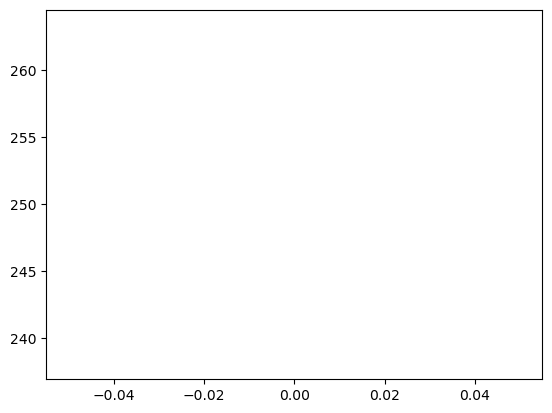

In [188]:
# plt.plot(out)
plt.plot(loss[2518,:])

In [97]:
pred_loss_value = jax.jit(jax.vmap(prediction_loss, in_axes=(None, None, 0, 0, 0, 0), out_axes=0))

In [15]:
theta_init = jnp.array([-6.0781652e-01, -7.4462712e-01,  3.5184588e+00,  5.4686189e-01,
       -1.0913883e+00,  5.2840942e-01,  3.4589937e+00, -2.6044300e+00,
        2.7951126e+00,  4.9484010e+00,  5.6696477e+00, -2.0681891e+00,
       -1.6069070e+00, -9.8562026e-01, -1.9708636e+00,  3.7333626e-01,
       -8.5588342e-01, -1.3457820e+00,  1.3749516e-01,  4.7659159e+00,
        5.6544399e+00, -1.6361110e+00, -1.0592579e+00, -1.8263711e+00,
       -6.5376675e-01,  5.3482950e-02, -8.1026787e-01, -1.2710721e+00,
        3.3735830e-01,  4.8072858e+00,  5.3927007e+00, -1.6410534e+00,
       -1.2736772e+00, -9.1073114e-01,  2.8500117e-02,  1.2802005e-01,
       -2.9407603e-01, -2.9304323e-01,  2.0585996e-03,  4.8657904e+00,
        5.7590842e+00, -2.1941569e+00, -1.6112928e+00, -1.3542119e+00,
       -2.1762712e+00,  4.2314015e-02, -3.0457318e-01, -1.3361717e+00,
        1.5368794e-01,  4.3093610e+00,  5.8076801e+00, -2.6438172e+00,
       -2.1497254e+00, -1.0340763e+00, -1.2143546e+00,  2.7606837e-02,
       -3.8350862e-01, -6.1475533e-01,  1.8734965e-01,  4.1830583e+00,
        5.3854079e+00, -1.7294077e+00, -1.2242651e+00, -9.2366338e-01,
       -1.3280846e+00,  1.1299133e-01, -1.3014480e+00, -1.0776204e+00,
        8.0365327e-04])

In [177]:
def reg_loss(theta, initial_params, params_lower, params_upper):
        return jnp.nansum((theta - initial_params)**2 / ((theta - params_lower) * (params_upper - theta)))

In [178]:
def prediction(theta, constants, x_forcing_nt, x_forcing_nyrs, x_maps, ys):
        return make_prediction_main(theta, constants, x_forcing_nt, x_forcing_nyrs, x_maps)

In [179]:
loss = pred_loss_value(theta_init, constants, x_forcing_nt, x_forcing_nyrs, x_maps, ys)

In [180]:
jnp.isnan(loss).any(axis=1).sum()

Array(20884, dtype=int32)

In [67]:
# Construct xr 
import xarray as xr
ds_grid = xr.open_dataset(f"{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/{obs_name}_validation.nc")
lons = ds_grid.lon
lats = ds_grid.lat

In [68]:
lons.shape

(317,)

In [69]:
lats.shape

(194,)

In [72]:
loss.reshape(len(lats), len(lons), loss.shape[1]).shape

(194, 317, 2555)

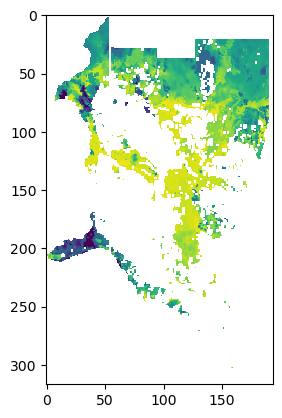

In [74]:
plt.imshow(loss.reshape(len(lons), len(lats), loss.shape[1])[:,:,1])

In [109]:
loss.shape

(30841, 2555)

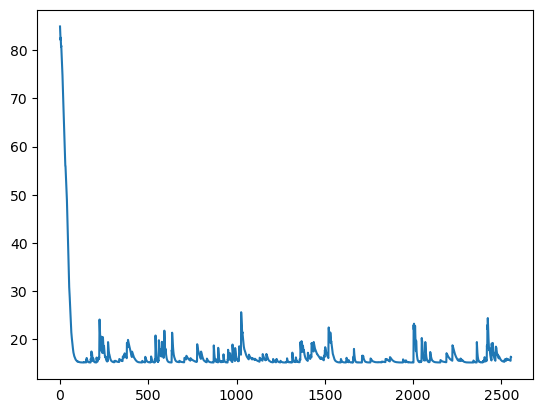

In [131]:
plt.plot(loss[10,:])

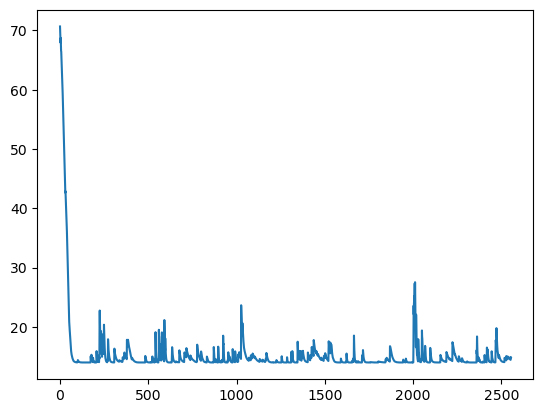

In [107]:
plt.plot(loss[0,:])

### SMAP

In [15]:
# Info
subset_name = 'centralUS'
obs_name = 'SMAP'

In [16]:
# Get dimensions
ys, _, _, _ = read_inputs(subset_name, obs_name, True)
Nspace = ys.shape[0]
Ntime = ys.shape[1]

# Get validation indices
val_frac = 0.2
val_inds_all = np.array_split(np.random.permutation(Nspace), 1/val_frac)

In [17]:
%%time
_error_fn = _rmse
error_fn_name = 'rmse'

train_loss_out, pred_loss_out, reg_loss_out, val_loss_out, theta = train_and_store(subset_name = subset_name,
                                                                                   obs_name = obs_name,
                                                                                   _error_fn = _error_fn,
                                                                                   val_inds = val_inds_all[0],
                                                                                   learning_rate = 1e-4,
                                                                                   error_fn_name = error_fn_name,
                                                                                   param_names = param_names,
                                                                                   n_epochs = 20)

Epoch 0 pred loss: 139.7927, reg_loss: 109.3204, val loss: 140.4135
Epoch 1 total loss: 135.2182, pred loss: 135.1628, reg_loss: 55.4158, val loss: 130.9500
Epoch 6 total loss: 77.2987, pred loss: 77.2152, reg_loss: 83.5444, val loss: 71.2894
Epoch 11 total loss: 40.2665, pred loss: 40.2246, reg_loss: 41.9135, val loss: 39.6651
Epoch 16 total loss: 35.5767, pred loss: 35.5234, reg_loss: 53.3870, val loss: 35.3186
Epoch 21 total loss: 34.5100, pred loss: 34.4479, reg_loss: 62.0669, val loss: 34.5404
CPU times: user 21min 45s, sys: 9.08 s, total: 21min 54s
Wall time: 22min 2s


In [24]:
%%time
# Parallelize with dask delayed
delayed = []

for _error_fn, error_fn_name in zip(_error_fns, error_fn_names):
    for _ in range(4):
        for val_inds in val_inds_all:
            delayed.append(dask.delayed(train_and_store)(subset_name = subset_name,
                                                         obs_name = obs_name,
                                                         _error_fn = _error_fn,
                                                         error_fn_name = error_fn_name,
                                                         val_inds = val_inds))

_ = dask.compute(*delayed)

CPU times: user 6min 41s, sys: 27.7 s, total: 7min 8s
Wall time: 51min 12s


### VIC

In [13]:
# Info
subset_name = 'centralUS'
obs_name = 'VIC'

In [14]:
# soil class scalar using log, random start, scaled
_error_fn = _rmse
error_fn_name = 'rmse'

train_loss_out, pred_loss_out, reg_loss_out, val_loss_out, theta = train_and_store(subset_name = subset_name,
                                                                                   obs_name = obs_name,
                                                                                   _error_fn = _error_fn,
                                                                                   error_fn_name = error_fn_name,
                                                                                   learning_rate = 0.001,
                                                                                   n_epochs = 30,
                                                                                   val_frac = 0.0)

Epoch 0 pred loss: 151.2948, reg_loss: 210.8976, val loss: nan
Epoch 1 total loss: 145.2396, pred loss: 144.4348, reg_loss: 80.4860, val loss: nan
Epoch 6 total loss: 69.4841, pred loss: 69.0368, reg_loss: 44.7317, val loss: nan
Epoch 11 total loss: 43.8797, pred loss: 43.6616, reg_loss: 21.8073, val loss: nan
Epoch 16 total loss: 33.9699, pred loss: 33.7160, reg_loss: 25.3886, val loss: nan
Epoch 21 total loss: 29.3166, pred loss: 29.0769, reg_loss: 23.9760, val loss: nan
Epoch 26 total loss: 26.9986, pred loss: 26.7692, reg_loss: 22.9425, val loss: nan
Epoch 31 total loss: 26.6741, pred loss: 26.4396, reg_loss: 23.4555, val loss: nan


In [12]:
# soil class scalar using log, random start
_error_fn = _rmse
error_fn_name = 'rmse'

train_loss_out, pred_loss_out, reg_loss_out, val_loss_out, theta = train_and_store(subset_name = subset_name,
                                                                                   obs_name = obs_name,
                                                                                   _error_fn = _error_fn,
                                                                                   error_fn_name = error_fn_name,
                                                                                   learning_rate = 0.001,
                                                                                   n_epochs = 30,
                                                                                   val_frac = 0.0)

Epoch 0 pred loss: 193.0402, reg_loss: 275.4830, val loss: nan
Epoch 1 total loss: 188.6235, pred loss: 187.8289, reg_loss: 79.4585, val loss: nan
Epoch 6 total loss: 126.1107, pred loss: 125.7390, reg_loss: 37.1648, val loss: nan
Epoch 11 total loss: 72.8450, pred loss: 72.5604, reg_loss: 28.4649, val loss: nan
Epoch 16 total loss: 46.6197, pred loss: 46.3994, reg_loss: 22.0373, val loss: nan
Epoch 21 total loss: 37.7458, pred loss: 37.4790, reg_loss: 26.6730, val loss: nan
Epoch 26 total loss: 33.6993, pred loss: 33.4204, reg_loss: 27.8836, val loss: nan
Epoch 31 total loss: 32.5981, pred loss: 32.3313, reg_loss: 26.6761, val loss: nan


In [17]:
# NOAH + regression on soil contents using log, random start
_error_fn = _rmse
error_fn_name = 'rmse'

train_loss_out, pred_loss_out, reg_loss_out, val_loss_out, theta = train_and_store(subset_name = subset_name,
                                                                                   obs_name = obs_name,
                                                                                   _error_fn = _error_fn,
                                                                                   error_fn_name = error_fn_name,
                                                                                   learning_rate = 0.001,
                                                                                   n_epochs = 30,
                                                                                   val_frac = 0.0)

Epoch 0 pred loss: 135.3471, reg_loss: 619.0754, val loss: nan
Epoch 1 total loss: 117.6131, pred loss: 116.4815, reg_loss: 113.1661, val loss: nan
Epoch 6 total loss: 51.9875, pred loss: 51.4211, reg_loss: 56.6422, val loss: nan
Epoch 11 total loss: 42.1469, pred loss: 41.7205, reg_loss: 42.6382, val loss: nan
Epoch 16 total loss: 38.3026, pred loss: 37.9357, reg_loss: 36.6916, val loss: nan
Epoch 21 total loss: 36.0634, pred loss: 35.7291, reg_loss: 33.4250, val loss: nan
Epoch 26 total loss: 34.8380, pred loss: 34.5312, reg_loss: 30.6831, val loss: nan
Epoch 31 total loss: 34.2670, pred loss: 33.9823, reg_loss: 28.4617, val loss: nan


In [20]:
# NOAH, log, random start
_error_fn = _rmse
error_fn_name = 'rmse'

train_loss_out, pred_loss_out, reg_loss_out, val_loss_out, theta = train_and_store(subset_name = subset_name,
                                                                                   obs_name = obs_name,
                                                                                   _error_fn = _error_fn,
                                                                                   error_fn_name = error_fn_name,
                                                                                   learning_rate = 0.001,
                                                                                   n_epochs = 30,
                                                                                   val_frac = 0.0)

Epoch 0 pred loss: 123.8417, reg_loss: 195.7297, val loss: nan
Epoch 1 total loss: 112.4669, pred loss: 111.8620, reg_loss: 60.4960, val loss: nan
Epoch 6 total loss: 64.0041, pred loss: 63.6166, reg_loss: 38.7476, val loss: nan
Epoch 11 total loss: 48.7567, pred loss: 48.4685, reg_loss: 28.8285, val loss: nan
Epoch 16 total loss: 44.0785, pred loss: 43.8326, reg_loss: 24.5905, val loss: nan
Epoch 21 total loss: 41.5831, pred loss: 41.3319, reg_loss: 25.1146, val loss: nan
Epoch 26 total loss: 39.6683, pred loss: 39.4182, reg_loss: 25.0046, val loss: nan
Epoch 31 total loss: 38.1857, pred loss: 37.9466, reg_loss: 23.9035, val loss: nan


In [15]:
# NOAH + regression on soil contents using log
_error_fn = _rmse
error_fn_name = 'rmse'

train_loss_out, pred_loss_out, reg_loss_out, val_loss_out, theta = train_and_store(subset_name = subset_name,
                                                                                   obs_name = obs_name,
                                                                                   _error_fn = _error_fn,
                                                                                   error_fn_name = error_fn_name,
                                                                                   learning_rate = 0.001,
                                                                                   n_epochs = 30,
                                                                                   val_frac = 0.0)

Epoch 0 pred loss: 139.6269, reg_loss: 0.0000, val loss: nan
Epoch 1 total loss: 115.5750, pred loss: 115.4117, reg_loss: 16.3227, val loss: nan
Epoch 6 total loss: 39.4394, pred loss: 39.2534, reg_loss: 18.6035, val loss: nan
Epoch 11 total loss: 36.1339, pred loss: 35.9304, reg_loss: 20.3449, val loss: nan
Epoch 16 total loss: 34.4622, pred loss: 34.2524, reg_loss: 20.9795, val loss: nan
Epoch 21 total loss: 33.8736, pred loss: 33.6661, reg_loss: 20.7497, val loss: nan
Epoch 26 total loss: 33.6492, pred loss: 33.4455, reg_loss: 20.3705, val loss: nan
Epoch 31 total loss: 33.4985, pred loss: 33.2909, reg_loss: 20.7576, val loss: nan


In [12]:
# Regression on soil contents plus intercept using log, random start
_error_fn = _rmse
error_fn_name = 'rmse'

train_loss_out, pred_loss_out, reg_loss_out, val_loss_out, theta = train_and_store(subset_name = subset_name,
                                                                                   obs_name = obs_name,
                                                                                   _error_fn = _error_fn,
                                                                                   error_fn_name = error_fn_name,
                                                                                   learning_rate = 0.001,
                                                                                   n_epochs = 30,
                                                                                   val_frac = 0.0)

Epoch 0 pred loss: 398.7293, reg_loss: 149.0950, val loss: nan
Epoch 1 total loss: 357.0240, pred loss: 356.3212, reg_loss: 70.2793, val loss: nan
Epoch 6 total loss: 109.7697, pred loss: 109.0889, reg_loss: 68.0762, val loss: nan
Epoch 11 total loss: 55.9770, pred loss: 55.7513, reg_loss: 22.5671, val loss: nan
Epoch 16 total loss: 46.4427, pred loss: 46.3075, reg_loss: 13.5284, val loss: nan
Epoch 21 total loss: 41.7153, pred loss: 41.5609, reg_loss: 15.4350, val loss: nan
Epoch 26 total loss: 39.8752, pred loss: 39.7038, reg_loss: 17.1428, val loss: nan
Epoch 31 total loss: 39.2561, pred loss: 39.0825, reg_loss: 17.3580, val loss: nan


In [27]:
# Regression on soil contents plus intercept using log
_error_fn = _rmse
error_fn_name = 'rmse'

train_loss_out, pred_loss_out, reg_loss_out, val_loss_out, theta = train_and_store(subset_name = subset_name,
                                                                                   obs_name = obs_name,
                                                                                   _error_fn = _error_fn,
                                                                                   error_fn_name = error_fn_name,
                                                                                   learning_rate = 0.001,
                                                                                   n_epochs = 30,
                                                                                   val_frac = 0.0)

Epoch 0 pred loss: 56.6325, reg_loss: 0.0000, val loss: nan
Epoch 1 total loss: 49.9408, pred loss: 49.8898, reg_loss: 5.1048, val loss: nan
Epoch 6 total loss: 40.4870, pred loss: 40.3236, reg_loss: 16.3395, val loss: nan
Epoch 11 total loss: 39.0435, pred loss: 38.8532, reg_loss: 19.0305, val loss: nan
Epoch 16 total loss: 38.5324, pred loss: 38.3486, reg_loss: 18.3766, val loss: nan
Epoch 21 total loss: 38.1424, pred loss: 37.9535, reg_loss: 18.8949, val loss: nan
Epoch 26 total loss: 37.8405, pred loss: 37.6562, reg_loss: 18.4250, val loss: nan
Epoch 31 total loss: 37.6220, pred loss: 37.4392, reg_loss: 18.2792, val loss: nan


In [14]:
# Regression on soil contents using log
_error_fn = _rmse
error_fn_name = 'rmse'

train_loss_out, pred_loss_out, reg_loss_out, val_loss_out, theta = train_and_store(subset_name = subset_name,
                                                                                   obs_name = obs_name,
                                                                                   _error_fn = _error_fn,
                                                                                   error_fn_name = error_fn_name,
                                                                                   learning_rate = 0.001,
                                                                                   n_epochs = 30,
                                                                                   val_frac = 0.0)

Epoch 0 pred loss: 56.2360, reg_loss: 0.0000, val loss: nan
Epoch 1 total loss: 49.7308, pred loss: 49.6789, reg_loss: 5.1875, val loss: nan
Epoch 6 total loss: 40.0404, pred loss: 39.8642, reg_loss: 17.6196, val loss: nan
Epoch 11 total loss: 39.1196, pred loss: 38.9322, reg_loss: 18.7309, val loss: nan
Epoch 16 total loss: 38.4627, pred loss: 38.2776, reg_loss: 18.5110, val loss: nan
Epoch 21 total loss: 37.9999, pred loss: 37.8117, reg_loss: 18.8236, val loss: nan
Epoch 26 total loss: 37.7233, pred loss: 37.5467, reg_loss: 17.6600, val loss: nan
Epoch 31 total loss: 37.5629, pred loss: 37.3785, reg_loss: 18.4447, val loss: nan


In [15]:
# Regression on soil contents using non-log
_error_fn = _rmse
error_fn_name = 'rmse'

train_loss_out, pred_loss_out, reg_loss_out, val_loss_out, theta = train_and_store(subset_name = subset_name,
                                                                                   obs_name = obs_name,
                                                                                   _error_fn = _error_fn,
                                                                                   error_fn_name = error_fn_name,
                                                                                   learning_rate = 0.001,
                                                                                   n_epochs = 30,
                                                                                   val_frac = 0.0)

Epoch 0 pred loss: 56.2178, reg_loss: 0.0000, val loss: nan
Epoch 1 total loss: 54.7293, pred loss: 54.6346, reg_loss: 9.4750, val loss: nan
Epoch 6 total loss: 46.0005, pred loss: 45.8825, reg_loss: 11.7977, val loss: nan
Epoch 11 total loss: 45.2821, pred loss: 45.1470, reg_loss: 13.5068, val loss: nan
Epoch 16 total loss: 44.7553, pred loss: 44.6166, reg_loss: 13.8699, val loss: nan
Epoch 21 total loss: 44.3233, pred loss: 44.1600, reg_loss: 16.3280, val loss: nan
Epoch 26 total loss: 43.9569, pred loss: 43.7966, reg_loss: 16.0265, val loss: nan
Epoch 31 total loss: 43.6540, pred loss: 43.4892, reg_loss: 16.4812, val loss: nan


In [ ]:
# %%time
# # Parallelize with dask delayed
# delayed = []

# for _error_fn, error_fn_name in zip(_error_fns, error_fn_names):
#     # Hyperparameter adjustments
#     if error_fn_name == 'kge':
#         reg_const = 0.001
#     else:
#         reg_const = 0.01

#     if error_fn_name == 'mse':
#         learning_rate = 1e-3
#     else:
#         learning_rate = 1e-2
        
#     for batch_size in [2**5, 2**6, 2**7, 2**8, 2**9]:
#         delayed.append(dask.delayed(train_and_store)(subset_name = subset_name,
#                                                      obs_name = obs_name,
#                                                      _error_fn = _error_fn,
#                                                      error_fn_name = error_fn_name,
#                                                      batch_size = batch_size,
#                                                      reg_const = reg_const,
#                                                      learning_rate = learning_rate,
#                                                      n_epochs = 30,
#                                                      val_frac = 0.0))

# out = dask.compute(*delayed)

### MOSAIC

In [18]:
# Info
subset_name = 'centralUS'
obs_name = 'MOSAIC'

# needed for quantile RMSE
N = np.load(f'{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/{obs_name}_validation.npy').shape[-1]

In [19]:
%%time
# Parallelize with dask delayed
delayed = []

for _error_fn, error_fn_name in zip(_error_fns, error_fn_names):
    # Hyperparameter adjustments
    if error_fn_name == 'kge':
        reg_const = 0.001
    else:
        reg_const = 0.01

    if error_fn_name == 'mse':
        learning_rate = 1e-3
    else:
        learning_rate = 1e-2
        
    for batch_size in [2**5, 2**6, 2**7, 2**8, 2**9]:
        delayed.append(dask.delayed(train_and_store)(subset_name = subset_name,
                                                     obs_name = obs_name,
                                                     _error_fn = _error_fn,
                                                     error_fn_name = error_fn_name,
                                                     batch_size = batch_size,
                                                     reg_const = reg_const,
                                                     learning_rate = learning_rate,
                                                     n_epochs = 30,
                                                     val_frac = 0.0))

out = dask.compute(*delayed)

CPU times: user 4min 23s, sys: 20.8 s, total: 4min 43s
Wall time: 56min 43s


### NOAH

In [20]:
# Info
subset_name = 'centralUS'
obs_name = 'NOAH'

# needed for quantile RMSE
N = np.load(f'{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/{obs_name}_validation.npy').shape[-1]

In [ ]:
%%time
# Parallelize with dask delayed
delayed = []

for _error_fn, error_fn_name in zip(_error_fns, error_fn_names):
    # Hyperparameter adjustments
    if error_fn_name == 'kge':
        reg_const = 0.001
    else:
        reg_const = 0.01

    if error_fn_name == 'mse':
        learning_rate = 1e-3
    else:
        learning_rate = 1e-2
        
    for batch_size in [2**5, 2**6, 2**7, 2**8, 2**9]:
        delayed.append(dask.delayed(train_and_store)(subset_name = subset_name,
                                                     obs_name = obs_name,
                                                     _error_fn = _error_fn,
                                                     error_fn_name = error_fn_name,
                                                     batch_size = batch_size,
                                                     reg_const = reg_const,
                                                     learning_rate = learning_rate,
                                                     n_epochs = 30,
                                                     val_frac = 0.0))

out = dask.compute(*delayed)